# DIQA Pipeline: Training and Inference Demo

This notebook demonstrates how to use the `DIQA` library for No-Reference Image Quality Assessment (NR-IQA).
We will cover:
1.  **Setup**: Installing the library.
2.  **Data Preparation**: Setting up a custom dataset.
3.  **Training**: Training a custom router using `DIQATrainer`.
4.  **Inference**: Using the trained `DIQA` model to score new images.

In [ ]:
# @title 1. Setup
# Install the package (uncomment if running in Colab and repo is cloned)
# !pip install .

In [10]:
import os
import pandas as pd
from pathlib import Path
from DIQA import DIQA, DIQATrainer

# Create a placeholder dataset for demonstration if none exists
IMAGE_DIR = Path("demo_images")
IMAGE_DIR.mkdir(exist_ok=True)

# You would normally upload your images here.
# For this demo, we'll check if there are images, if not, we can't train.
print(f"Looking for images in {IMAGE_DIR.absolute()}")

Looking for images in d:\Github\NR-IQA\demo_images


## 2. Training a Custom Router

To train a custom router, you need:
1.  A directory of images.
2.  A CSV file containing the Mean Opinion Score (MOS) for each image.
    -   Columns: `image_name`, `MOS`

Starting Training Pipeline...
Loading MOS data...
Sampling 100 images...
Extracting features...


Extracting Features: 100%|██████████| 100/100 [00:00<00:00, 101.27it/s]


Computing IQA scores...
Merging data...
Training mapping coefficients...
Training XGBoost router...
Train Acc: 1.0000, Test Acc: 0.3000
Training Complete!
Test Accuracy: 0.3000


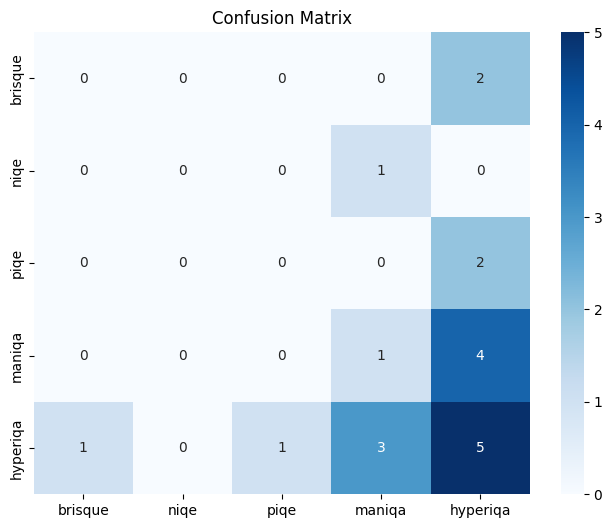

In [11]:
# @title Define Training Parameters
MOS_CSV = "Data/koniq10k_scores_and_distributions.csv" # @param {type:"string"}
IMAGE_FOLDER = "koniq10k_512x384" # @param {type:"string"}
SAMPLE_SIZE = 100 # @param {type:"integer"} - Set to None to use all data

if os.path.exists(MOS_CSV) and os.path.exists(IMAGE_FOLDER):
    print("Starting Training Pipeline...")
    
    # Initialize Trainer
    trainer = DIQATrainer(IMAGE_FOLDER, MOS_CSV, output_dir="DIQA/models")
    
    # Prepare Data (Extract features, Compute/Load Scores)
    # This will use the cached scores in Data/iqa_raw_scores.csv if available
    trainer.prepare_data(sample_size=SAMPLE_SIZE)
    
    # Train the model
    results = trainer.train(test_split=0.2)
    
    print("Training Complete!")
    print(f"Test Accuracy: {results['test_acc']:.4f}")
    
    # Plot Confusion Matrix
    trainer.plot_confusion_matrix(results['X_test'], results['y_test'], results['router'])
else:
    print("Dataset not found. Please upload data to run training.")

## 3. Inference

Once trained (or using the pretrained models), you can score new images.

In [9]:
# Initialize the DIQA engine
diqa = DIQA(model_dir="DIQA/models")

# Pick a random image to test
if os.path.exists(IMAGE_FOLDER):
    import random
    test_images = list(Path(IMAGE_FOLDER).glob("*.jpg"))
    if test_images:
        sample_img = random.choice(test_images)
        
        print(f"Scoring {sample_img.name}...")
        result = diqa.predict(sample_img)
        
        print("-" * 30)
        print(f"Predicted MOS: {result['MOS_estimate']:.3f}")
        print(f"Method Used:   {result['selected_method']} (Conf: {result['confidence']:.2f})")
        print(f"Time Taken:    {result['timing']['total_time_ms']:.1f} ms")
        print("-" * 30)

Scoring 3542002438.jpg...
Loading hyperiqa model...
Loading pretrained model HyperNet from C:\Users\aryam\.cache\torch\hub\pyiqa\HyperIQA-resnet50-koniq10k-c96c41b1.pth
------------------------------
Predicted MOS: 2.969
Method Used:   hyperiqa (Conf: 0.88)
Time Taken:    1367.5 ms
------------------------------
